# working with priors

In Bayesian statistics a prior is used to specify prior belief.
Working with priors to improve estimates of undersampled populations.
Priors can be based on other related, populations, or specified by
hand.

In [1]:
import HLAfreq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Venezuela is one of the least sampled countries on allelefrequency.net
We found only 55 gold standard samples for HLA A.

In [2]:
# Download data for Venezuela
country = "Venezuela"
base_url = HLAfreq.makeURL(country, locus="A", standard="g",)
venezuelaAF = HLAfreq.getAFdata(base_url)

1 pages of results
Download complete


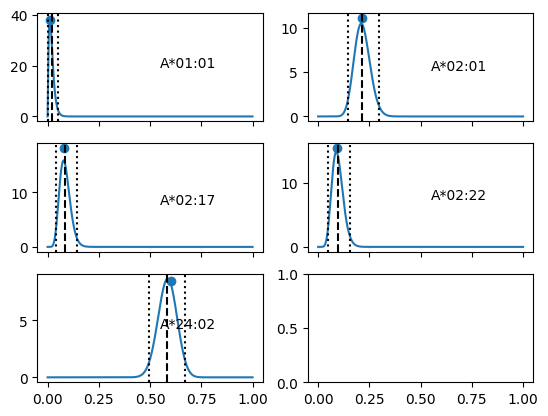

In [4]:
venezuelaAF = HLAfreq.only_complete(venezuelaAF)
venezuelaAF = HLAfreq.decrease_resolution(venezuelaAF, 2)
cafV = HLAfreq.combineAF(venezuelaAF)
cafV['study'] =  'Venezuela'
HLAfreq.plotAFprob(cafV, venezuelaAF)

We can specify priors manually, this could be any
$n$ length list of positive real numbers.

The interpretation of the prior is that $n$ copies were found for each
allele. Note that `combineAF()` uses the first value in the prior for
the first allele alphabetically and so on.

By viewing the posterior we can see that the prior has moved the
estimate away from the observed study.

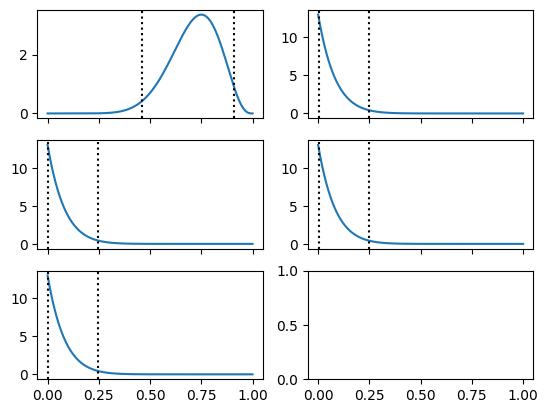

In [6]:
manual_prior = [10, 1, 1, 1, 1]

# View prior distribution
HLAfreq.plotAFprob(concentration=manual_prior)


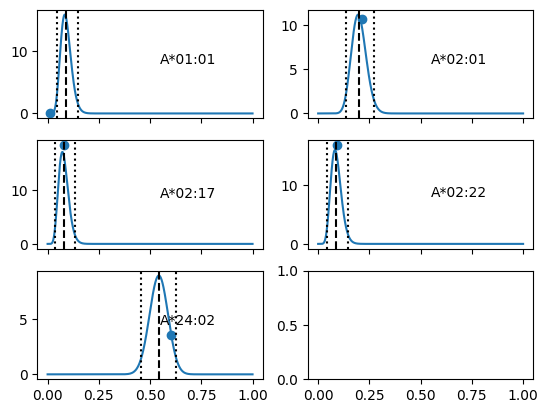

In [7]:

# Combine Allele Freq of study with Manual Prior
cafMP = HLAfreq.combineAF(venezuelaAF, alpha=manual_prior)

# View posterior distribution
HLAfreq.plotAFprob(cafMP, AFtab=venezuelaAF)

Alternatively we can use another population as our prior.
For example we will use data for Colombia, a neighbouring country
with many more samples for HLA A.

When using other studies as a prior we can downweight their samples
so they count less than the samples in our actual population.
The amount of downweighting depends on how relevent you believe the
other study is. Here we arbitrarily downweight by a factor 0.01 as
an example so that the Venezuela data is not drowned out by the Colombia data.

When recalculating the prior to plot, sample size is doubled
as each person in the study is diploid and so provides two alleles.

In [12]:
# Download data for Colombia
country = "Colombia"
base_url = HLAfreq.makeURL(country, locus="A", standard="g",)
colombiaAF = HLAfreq.getAFdata(base_url)

1 pages of results
Download complete


In [13]:
# Combine Colombia studies into a national average
colombiaAF = HLAfreq.only_complete(colombiaAF)
colombiaAF = HLAfreq.decrease_resolution(colombiaAF, 2)
cafC = HLAfreq.combineAF(colombiaAF)
cafC['population'] =  'Colombia'

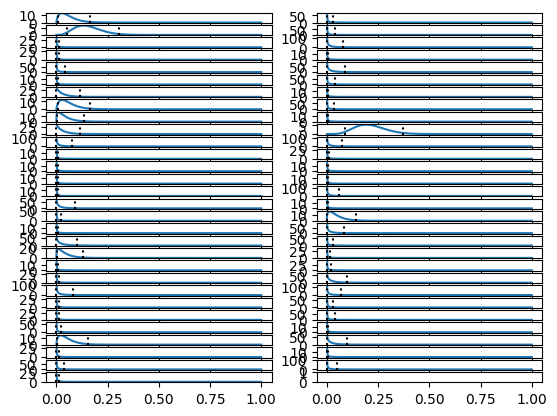

In [16]:
# Create a prior from Colombia
study_prior = cafC.copy()
study_prior.sample_size = study_prior.sample_size * 0.01

# View prior
HLAfreq.plotAFprob(
    concentration = (2 * study_prior.sample_size * study_prior.allele_freq).tolist()
)


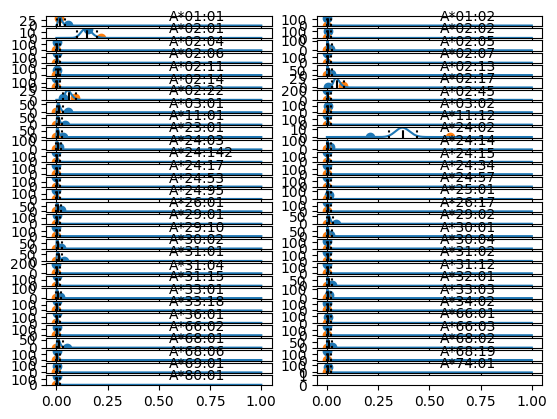

In [17]:
# Combine Allele Frequency with Study Prior
cafSP = HLAfreq.combineAF(
    pd.concat([venezuelaAF, study_prior], join="inner")
    )

# View posterior of all alleles
HLAfreq.plotAFprob(cafSP, pd.concat([venezuelaAF, study_prior], join="inner"))


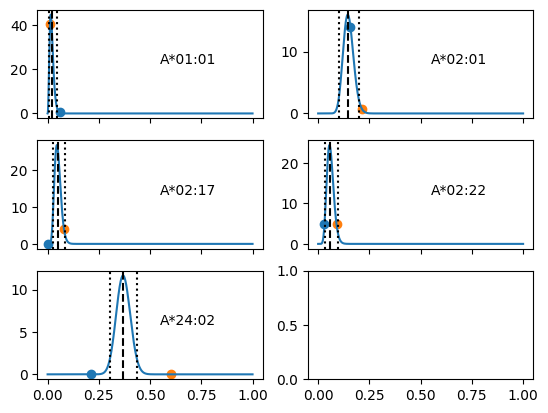

In [18]:
# View posterior of just alleles observed in Venezuela
HLAfreq.plotAFprob(cafSP, pd.concat([venezuelaAF, study_prior], join="inner"), alleles=venezuelaAF.allele.tolist())